# Homework 1 (Total Points: 175)



Learning Goals:
- Learn how to load a dataset and process it.
- Learn how to implement several IR methods (TFIDF, BM25, QL) and understand their weaknesses & strengths.
- Learn how to evaluate IR methods


**NOTE 1**: Only the code (`TODO: Implement this!` denotes these sections) is graded. The 'theory' questions in this assignment serve as a preparation for the exam and to facilitate a deeper understanding of the course content. These questions (denoted by `TODO: Answer this!`) have no points assigned to them, but **need** to be filled out before submission.  

**NOTE 2**: You can use the `nltk`, `numpy` and `matplotlib` libraries here. Other libraries, e.g., `gensim` or `scikit-learn`, may not be used. 

**NOTE 3**: The notebook you submit has to have the student ids, seperated by underscores (E.g., `12341234_12341234_12341234.ipynb`). 

**NOTE 4**: Make sure to check that your notebook runs before submission. A quick way to do this is to restart the kernel and run all the cells.  

---
Additional Resources: 
-  Sections 2.3, 4.1, 4.2, 4.3, 5.3, 5.6, 5.7, 6.2, 7, 8 of [Search Engines: Information Retrieval in Practice](https://ciir.cs.umass.edu/downloads/SEIRiP.pdf)


In [58]:
# imports 
# TODO: Ensure that no additional library is imported in the notebook. 
# TODO: Only the standard library and the following libraries are allowed:

import os
import zipfile
from functools import partial

import nltk
import requests
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

from ipywidgets import widgets
from IPython.display import display, HTML
from IPython.html import widgets
from collections import namedtuple

%matplotlib inline


## Section 1: Text Processing (20 points)

In this section, we will load the dataset and learn how to clean up the data to make it usable for an IR system. 

We are using the [CACM dataset](http://ir.dcs.gla.ac.uk/resources/test_collections/cacm/), which is a small, classic IR dataset, composed of a collection of titles and abstracts from the journal CACM. It comes with relevance judgements for queries, so we can evaluate our IR system. 

The following cell downloads the dataset and unzips it to a local directory

In [59]:
def download_dataset(folder_path = "./datasets/"):
    
    os.makedirs(folder_path, exist_ok=True)
    
    file_location = os.path.join(folder_path, "cacm.zip")
    
    # download file if it doesn't exist
    if not os.path.exists(file_location):
        
        url = "https://surfdrive.surf.nl/files/index.php/s/M0FGJpX2p8wDwxR/download"

        with open(file_location, "wb") as handle:
            print(f"Downloading file from {url} to {file_location}")
            response = requests.get(url, stream=True)
            for data in tqdm(response.iter_content()):
                handle.write(data)
            print("Finished downloading file")
    
    if not os.path.exists(os.path.join(folder_path, "train.txt")):
        
        # unzip file
        with zipfile.ZipFile(file_location, 'r') as zip_ref:
            zip_ref.extractall(folder_path)
        
download_dataset()

You can see a brief description of each file in the dataset by looking at the README file

In [60]:
##### Read the README file 
!cat ./datasets/README
#####

Files in this directory with sizes:
          0 Jun 19 21:01 README

    2187734 Jun 19 20:55 cacm.all              text of documents
        626 Jun 19 20:58 cite.info             key to citation info
                                                (the X sections in cacm.all)
       2668 Jun 19 20:55 common_words           stop words used by smart
       2194 Jun 19 20:55 make_coll*             shell script to make collection
       1557 Jun 19 20:55 make_coll_term*        ditto (both useless without
                                                smart system)
       9948 Jun 19 20:55 qrels.text             relation giving
                                                    qid did 0 0
                                                to indicate dument did is
                                                relevant to query qid
      13689 Jun 19 20:55 query.text             Original text of the query


----
We are interested in 4 files:
- `cacm.all` : Contains the text for all documents. Note that some documents do not have abstracts available. 
- `query.text` : The text of all queries
- `qrels.text` : The relevance judgements
- `common_words` : A list of common words. This may be used as a collection of stopwords

In [61]:
##### The first 45 lines of the CACM dataset forms the first record
# We are interested only in 3 fields. 
# 1. the '.I' field, which is the document id
# 2. the '.T' field (the title) and
# 3. the '.W' field (the abstract, which may be absent)
!head -45 ./datasets/cacm.all
#####

.I 1
.T
Preliminary Report-International Algebraic Language
.B
CACM December, 1958
.A
Perlis, A. J.
Samelson,K.
.N
CA581203 JB March 22, 1978  8:28 PM
.X
100	5	1
123	5	1
164	5	1
1	5	1
1	5	1
1	5	1
205	5	1
210	5	1
214	5	1
1982	5	1
398	5	1
642	5	1
669	5	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
165	6	1
196	6	1
196	6	1
1273	6	1
1883	6	1
324	6	1
43	6	1
53	6	1
91	6	1
410	6	1
3184	6	1


---

Now, write a function to read in the `cacm.all` file. Note that each document has a variable number of lines. The `.I` field denotes a new document

In [62]:
# TODO: Implement this! (4 points)

def traverse_field(text, i):
    
    if text[i][0] == "." and text[i][1].isupper():
        return "", i
    
    field = text[i][:-1]
    i += 1
    
    while text[i][0] != "." and not text[i][1].isupper():
        if text[i][0] == " " or field[-1] == " ":
            field += text[i][:-1]
        else:
            field += " " + text[i][:-1]
        i += 1
        
    return field, i


def read_cacm_docs(root_folder = "./datasets/"):
    """
        Reads in the CACM documents. The dataset is assumed to be in the folder "./datasets/cacm" be default
        Returns: A list of 2-tuples: (doc_id, document), where 'document' is a single string created by 
            appending the title and abstract (seperated by a "\n"). 
            In case the record doesn't have an abstract, the document is composed only by the title
    """
    
    docs = []
    with open(root_folder + "cacm.all", "r") as f:
        text = f.readlines()
        i = 0
        while i < (len(text)):
            
            if text[i][:2] == ".I":
                if i != 0:
                    docs.append((doc_id, document))
                doc_id = text[i][3:-1]
                
            if text[i][:2] == ".T":
                document, i = traverse_field(text, i+1)

            if text[i][:2] == ".W":
                abstract, i = traverse_field(text, i+1)
                document += "\n" + abstract
            
            i+=1     
        docs.append((doc_id, document))
    return docs

docs = read_cacm_docs()

In [63]:
##### 
assert len(docs) == 3204, "There should be exactly 3204 documents"
##### 

---

Next, let us read the queries. They are formatted similarly: 

In [64]:
##### The first 15 lines of 'query.text' has 2 queries
# We are interested only in 2 fields. 
# 1. the '.I' - the query id
# 2. the '.W' - the query
# 3. the '.W' field (the abstract, which may be absent)
!head -15 ./datasets/query.text
#####

.I 1
.W
 What articles exist which deal with TSS (Time Sharing System), an
operating system for IBM computers?
.N
 1. Richard Alexander, Comp Serv, Langmuir Lab (TSS)
 
.I 2
.W
 I am interested in articles written either by Prieve or Udo Pooch
.A
Prieve, B.
Pooch, U.
.N
 2. Richard Alexander, Comp Serv, Langmuir Lab (author = Pooch or Prieve)


---

Now, write a function to read in this file:

In [65]:
# TODO: Implement this! (3 points)
def read_queries(root_folder = "./datasets/"):
    """
        Reads in the CACM queries. The dataset is assumed to be in the folder "./datasets/" be default
        Returns: A list of 2-tuples: (query_id, query)
    """
    
    queries = []
    with open(root_folder + "query.text", "r") as f:
        text = f.readlines()
        i = 0
        while i < (len(text)):
            
            if text[i][:2] == ".I":
                if i != 0:
                    queries.append((query_id, query))
                query_id = text[i][3:-1]
                
            if text[i][:2] == ".W":
                query, i = traverse_field(text, i+1)

            i += 1        
        queries.append((query_id, query[1:]))
    return queries

queries = read_queries()

In [66]:
##### 
assert len(queries) == 64 and all([q[1] is not None for q in queries]), "There should be exactly 64 queries"
##### 

---

Read in the stop words:

In [67]:
!head ./datasets/common_words

a
about
above
accordingly
across
after
afterwards
again
against
all


In [68]:
# TODO: Implement this! (3 points)
def load_stopwords(root_folder = "./datasets"):
    """
    Load the stopwords
    Output: A set of stopwords
    """
    
    with open(root_folder + "/common_words", "r") as f:       
        return set(f.readlines())

stopwords = load_stopwords()
assert len(stopwords) == 428

--- 

We can now write some basic text processing functions. A first step is to tokenize the text. You may use any tokenizer available in the `nltk` library:

In [69]:
# TODO: Implement this! (5 points)
from nltk.tokenize import TweetTokenizer

def tokenize(text):
    """
        Tokenize the text. 
        Input: text - a string
        Output: a list of tokens
    """
    return TweetTokenizer().tokenize(text)

In [70]:
#####
text = "the quick brown fox jumps over the lazy dog"
tokens = tokenize(text)
print(tokens)
#####

['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']


---

*Answer the following questions*: 
- Why is stemming necessary, in particular for IR?
    - *TODO: Answer this!*
- Is there any setting (domain, scenario, etc) in which stemming can hurt performance? Illustrate with an example
    - *TODO: Answer this!*

Write a function to stem tokens. Again, you can use the `nltk` library for this

In [71]:
# TODO: Implement this! (5 points)
from nltk.stem.snowball import EnglishStemmer

def stem_token(token):
    """
        Stem the given token, using any stemmer available from the nltk library
        Input: a single token
        Output: the stem of the token
    """
    return EnglishStemmer().stem(token)

In [72]:
####
print([stem_token(t) for t in tokens])
tokens_ = [
    'caresses', 'flies', 'dies', 'mules', 'denied',
    'died', 'agreed', 'owned', 'humbled', 'sized',
    'meeting', 'stating', 'siezing', 'itemization',
    'sensational', 'traditional', 'reference', 'colonizer',
    'plotted']
print([stem_token(t) for t in tokens_])
####

['the', 'quick', 'brown', 'fox', 'jump', 'over', 'the', 'lazi', 'dog']
['caress', 'fli', 'die', 'mule', 'deni', 'die', 'agre', 'own', 'humbl', 'size', 'meet', 'state', 'siez', 'item', 'sensat', 'tradit', 'refer', 'colon', 'plot']


---

*Answer the following questions*: 
- Another processing step (not done here) is to use n-grams. Illustrate why you would want to use n-grams in IR with an example.  
    - *TODO: Answer this!*
- Usage of n-grams exacerbates some problems ex. in bi-gram language models. What is this problem? Suggest one solution 
    - *TODO: Answer this!*

--- 

The following function puts it all together. Given a string, it tokenizes it, and processes it according to the flags that you set.

In [73]:
#### Putting it all together
def process_text(text, stem=False, remove_stopwords=False, lowercase_text=False):
    
    tokens = []
    for token in tokenize(text):
        if remove_stopwords and token.lower() in stopwords:
            continue
        if stem:
            token = stem_token(token)
        if lowercase_text:
            token = token.lower()
        tokens.append(token)

    return tokens
#### 

Let's create two sets of pre-processed documents

In [74]:
# In this configuration:
# Don't preprocess the text, except to tokenize 
config_1 = {
  "stem": False,
  "remove_stopwords" : False,
  "lowercase_text": True
} 


# In this configuration:
# Preprocess the text: stem and remove stopwords
config_2 = {
  "stem": True,
  "remove_stopwords" : True,
  "lowercase_text": True, 
} 


We can now process the documents and queries according to the configuration specified above

In [75]:
####
doc_repr_1 = []
doc_repr_2 = []
for (doc_id, document) in docs:
    doc_repr_1.append((doc_id, process_text(document, **config_1)))
    doc_repr_2.append((doc_id, process_text(document, **config_2)))

####


--- 

## Section 2: Indexing (10 points)


A retrieval function usually takes in a query document pair, and scores a query against a document.  Our document set is quite small - just a few thousand documents. However, consider a web-scale dataset with a few million documents. In such a scenario, it would become infeasible to score every query and document pair. In such a case, we can build an inverted index. From Wikipedia:

> ... , an inverted index (also referred to as a postings file or inverted file) is a database index storing a mapping from content, such as words or numbers, to its locations in a table, .... The purpose of an inverted index is to allow fast full-text searches, at a cost of increased processing when a document is added to the database. ...


Consider a simple inverted index, which maps from word to document. This can improve the performance of a retrieval system significantly. In this assignment, we consider a *simple* inverted index, which maps a word to a set of documents. In practice, however, more complex indices might be used.  


### Building an index

A retrieval function usually takes in a query document pair, and scores a query against a document.  Our document set is quite small - just a few thousand documents. However, consider a web-scale dataset with a few million documents. In such a scenario, it would become infeasible to score every query and document pair. In such a case, we can build an inverted index. From Wikipedia:

> ... , an inverted index (also referred to as a postings file or inverted file) is a database index storing a mapping from content, such as words or numbers, to its locations in a table, .... The purpose of an inverted index is to allow fast full-text searches, at a cost of increased processing when a document is added to the database. ...


Consider a simple inverted index, which maps from word to document. This can improve the performance of a retrieval system significantly. In this assignment, we consider a *simple* inverted index, which maps a word to a set of documents. In practice, however, more complex indices might be used.  


---

In this assignment we will be using an index created in memory, since our dataset is tiny. To get started, build a simple index that maps simply counts the number of tokens present in a document. This index  is built using a python dictionary.

*Answer the following questions*:
- What is the time complexity of retrieving a list of documents from a python `dict` object? 
    - *TODO: Answer this!*
- Consider the case with a 10 million documents. What is the time complexity of retrieval with an inverted index (assuming you can fit the entire index in memory)? (Hint: Consider length of a query $|q|$) 
    - *TODO: Answer this!*
- For a large enough collection, we cannot store an index in memory. How is this tackled in practice (briefly explain)? Comment on the time complexity. 
    - *TODO: Answer this!*
- Mention a use-case in which a simple index (from word -> doc_id) might not suffice anymore. How would you modify the index to suit this use-case (if you can!)  
    - *TODO: Answer this!*
    
    
Now, implement a function to build an index:

In [76]:
from collections import defaultdict

#10 points
def build_tf_index(documents):
    """
    Build an inverted index (with counts). The output is a dictionary which takes in a token
    and returns a list of (doc_id, count) where 'count' is the count of the 'token' in 'doc_id'
    Input: a list of documents - (doc_id, tokens) 
    Output: An inverted index. [token] -> [(doc_id, token_count)]
    """
    
    inv_idx = defaultdict(list)
    for (doc_id, doc) in documents:
        
        doc_counts = {}
        for token in doc:
            if token not in doc_counts:
                doc_counts[token] = 1
            else:
                doc_counts[token] += 1
        
        for key in doc_counts:
            inv_idx[key].append((doc_id, doc_counts[key]))
                
    return inv_idx 
    
        
# Create the 2 indices
tf_index_1 = build_tf_index(doc_repr_1)
tf_index_2 = build_tf_index(doc_repr_2)


# This function returns the correct index 
def get_index(index_set):
    assert index_set in {1, 2}
    return {
        1: tf_index_1,
        2: tf_index_2
    }[index_set]


# This function correctly pre-processes the text given the index set
def preprocess_query(text, index_set):
    assert index_set in {1, 2}
    if index_set == 1:
        return process_text(text, **config_1)
    elif index_set == 2:
        return process_text(text, **config_2)
    

--- 

## Section 3: Retrieval  (80 points)

Now that we have cleaned and processed our dataset, we can start building simple IR systems. 

For now, we consider *simple* IR systems, which involve computing scores from the tokens present in the document/query. More advanced methods are covered in later assignments.

We will implement the following methods in this section:
- TF-IDF
- BM25
- Query Likelihood Models

--- 

### Ranking functions


Probably the simplest IR model is the Bag of Words (BOW) model. Implement a function that scores a query against a document using this model.   

Note that you can use either the count of the token or 'binarize' it i.e set the value equal to 1 if the token appears.   


**Note:** Make sure you use the `get_index` function to retrieve the correct index, and call `preprocess_query` with the correct index!

In [77]:
# 10 points
def bow_search(query, index_set):
    """
        Perform a search over all documents with the given query. 
        Note #1: You have to use the `get_index` function created in the previous cells
        Note #2: You can binarize the counts if you wish to
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    
    index = get_index(index_set)
    tok_query = preprocess_query(query, index_set)
    rel_list = defaultdict(int)
    
    for token in tok_query:
        if token in index:
            for (doc_id, count) in index[token]:
                rel_list[doc_id] += count
    
    rel_sum = sum(rel_list.values())
    for k in rel_list: 
        rel_list[k] /= rel_sum
        
    return sorted(rel_list.items(), key = lambda rl:(rl[1], rl[0]), reverse = True)

*Answer the following questions*: 
- The BOW model is might not be a good choice for use in IR. Why? 
    - *TODO: Answer this!*

In [78]:
####
docs_by_id = dict(docs)
def print_results(docs, len_limit=50):    
    for i, (doc_id, score) in enumerate(docs):
        doc_content = docs_by_id[doc_id].strip().replace("\n", "\\n")[:len_limit] + "..."
        print(f"Rank {i}({score:.2}): {doc_content}")

test_bow = bow_search("report", index_set=1)[:5]
print(f"BOW Results:")
print_results(test_bow)
#### 

BOW Results:
Rank 0(0.076): Rejuvenating Experimental Computer Science\nThis r...
Rank 1(0.045): An Information Algebra - Phase I Report-Language S...
Rank 2(0.03): ALGOL 60 Confidential\nThe ALGOL 60 Report,* when ...
Rank 3(0.03): Revised Report on the Algorithmic Language ALGOL 6...
Rank 4(0.03): Introduction to "Feature Analysis of Generalized D...


Before we implement the tf-idf scoring functions, let's first write a function to compute the document frequencies of all words.  

In [79]:
# 5 points
def compute_df(documents):
    """
        Compute the document frequency of all terms in the vocabulary
        Input: A list of documents
        Output: A dictionary with {token: document frequency)
    """
    
    df = defaultdict(int)
    for doc in documents:
        for token in doc:
            df[token] += 1
       
    return df


# get the document frequencies of each document
df_1 = compute_df([d[1] for d in doc_repr_1])
df_2 = compute_df([d[1] for d in doc_repr_2])

def get_df(index_set):
    assert index_set in {1, 2}
    return {
        1: df_1,
        2: df_2
    }[index_set]

Next, implement a function that computes a tf-idf score given a query.      

In [80]:
# TODO: Implement this! 10 points

def get_doc_ids(index):
    doc_ids = set([])
    for token in index:
        for (d_id, c) in index[token]:
            doc_ids.add(d_id)
    return doc_ids
    
    
def tfidf_search(query, index_set):
    """
        Perform a search over all documents with the given query using tf-idf. 
        Note #1: You have to use the `get_index` (and the `get_df`) function created in the previous cells
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    index = get_index(index_set)
    N = len(get_doc_ids(index))
    tok_query = preprocess_query(query, index_set)
    df = get_df(index_set)
    rel_list = defaultdict(int)
    
    for token in tok_query:
        if token in index:
            idf = np.log10(N / df[token])
            for (doc_id, tf) in index[token]:
                rel_list[doc_id] += tf * idf
                    
    rel_sum = sum(rel_list.values())
    for k in rel_list: 
        rel_list[k] /= rel_sum
    return sorted(rel_list.items(), key = lambda rl:(rl[1], rl[0]), reverse = True)    

In [81]:
####
test_tfidf = tfidf_search("report", index_set=1)[:5]
print(test_tfidf)
print(f"TFIDF Results:")
print_results(test_tfidf)
####

[('3160', 0.07575757575757572), ('616', 0.04545454545454543), ('321', 0.030303030303030287), ('3184', 0.030303030303030287), ('2198', 0.030303030303030287)]
TFIDF Results:
Rank 0(0.076): Rejuvenating Experimental Computer Science\nThis r...
Rank 1(0.045): An Information Algebra - Phase I Report-Language S...
Rank 2(0.03): ALGOL 60 Confidential\nThe ALGOL 60 Report,* when ...
Rank 3(0.03): Revised Report on the Algorithmic Language ALGOL 6...
Rank 4(0.03): Introduction to "Feature Analysis of Generalized D...


*Answer the following questions*: 
- It is generally not advisable to use the naive version of tf-idf. Why?
    - *TODO: Answer this!*
- Illustrate with an example why using a sublinear scaling for TF is preferable in some cases.  
    - *TODO: Answer this!*

--- 

*Answer the following questions*: 
- An alternative way to compute a query<>document score is to vectorize both the query and document (where each dimension corresponds to a token), and compute a score. The score can be computed using a dot product between the query and the document vectors. Why is the cosine similary function a better choice, particularly in IR? 
    - *TODO: Answer this!*
- What is the time complexity of a search if we are using the vector space method mentioned in the previous question? What is the time complexity if we're using an index (assume that it fits in memory)? Assume $N$ is the number of documents and $|q|$ is the length of a query. 
    - *TODO: Answer this!*

# --- 

#### Query Likelihood Models

In this section you will implement a simple query likelihood model. 

First, let use implement a naive version of a QL model, assuming a multinomial unigram language model (with a uniform prior over the documents). 

**Note:** Make sure you use the `get_index` function to retrieve the correct index, and call `preprocess_query` with the correct index!

--- 

*Answer the following questions*: 
- Write down the formula for computing the query likelihood, assuming a multinomial unigram language model. 
    - $\prod_{t \in q} P(t|M_d) = \frac{tf(t,d)}{dl(d)}$
- What problem does this naive method have? Suggest a simple way to fix it.
    - If a term from the query is not in the document the probability for a document will become 0 due to multiplication by 0. A solution is to use smoothing, of which there are multiple options.

In [82]:
####
def doc_lengths(documents):
    doc_lengths = {doc_id:len(doc) for (doc_id, doc) in documents}
    return doc_lengths

doc_lengths_1 = doc_lengths(doc_repr_1)
doc_lengths_2 = doc_lengths(doc_repr_2)

def get_doc_lengths(index_set):
    assert index_set in {1, 2}
    return {
        1: doc_lengths_1,
        2: doc_lengths_2
    }[index_set]
####

In [83]:

# TODO: Implement this! 15 points
def naive_ql_search(query, index_set):
    """
        Perform a search over all documents with the given query using a naive QL model. 
        Note #1: You have to use the `get_index` (and get_doc_lengths) function created in the previous cells
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    
    index = get_index(index_set)
    tok_query = preprocess_query(query, index_set)
    doc_lengths = get_doc_lengths(index_set)
    scores = defaultdict(list)
        
    for token in tok_query:
        token_score = {doc: 0 for doc in doc_lengths}
        
        if token in index:
            for (doc_id, tf) in index[token]:
                  token_score[doc_id] = tf
                    
            for doc in token_score:
                scores[doc].append(token_score[doc])
                
    rel_list = {doc: np.prod(scores[doc])/doc_lengths[doc] for doc in scores}
    rel_sum = sum(rel_list.values())
    for k in rel_list: 
        rel_list[k] /= rel_sum
    
    return sorted(rel_list.items(), key = lambda rl:(rl[1], rl[0]), reverse = True)      

In [84]:
####
test_naiveql = naive_ql_search("report", index_set=1)[:5]
print(f"TFIDF Results:")
print_results(test_naiveql)
####

TFIDF Results:
Rank 0(0.082): ALGOL Sub-Committee Report - Extensions...
Rank 1(0.082): A Report Writer For COBOL...
Rank 2(0.082): A CRT Report Generating System...
Rank 3(0.068): Supplement to the ALGOL 60 Report...
Rank 4(0.058): Report on the Algorithmic Language FORTRAN II...


Now, let's implement a (slightly more) complex QL model. This model should 'fix' the issue with the previous method. If your model requires hyperparameters, set a reasonable value. 

In [85]:
# TODO: Implement this! 20 points
def ql_search(query, index_set):
    """
        Perform a search over all documents with the given query using a appropriate QL model. 
        Note #1: You have to use the `get_index` (and get_doc_lengths) function created in the previous cells
        Note #2: You might have to create some variables beforehand and use them in this function
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    
    index = get_index(index_set)
    tok_query = preprocess_query(query, index_set)
    doc_lengths = get_doc_lengths(index_set)
    scores = defaultdict(list)
    for token in tok_query:
        token_score = {doc: 0.5 for doc in doc_lengths}
        
        if token in index:
            for (doc_id, tf) in index[token]:
                  token_score[doc_id] = tf
                    
            for doc in token_score:
                scores[doc].append(token_score[doc])
                
    rel_list = {doc: np.prod(scores[doc])/ (doc_lengths[doc] + 0.5 * len(tok_query)) for doc in scores}
    rel_sum = sum(rel_list.values())
    for k in rel_list: 
        rel_list[k] /= rel_sum
    
    return sorted(rel_list.items(), key = lambda rl:(rl[1], rl[0]), reverse = True)      

In [86]:
#### Test the QL model
test_ql_results = ql_search("report", index_set=1)[:5]
print_results(test_ql_results)
print()
test_ql_results_long = ql_search("report " * 10, index_set=1)[:5]
print_results(test_ql_results_long)
####

Rank 0(0.0028): COBOL...
Rank 1(0.0028): COMIT...
Rank 2(0.0028): FORTRAN...
Rank 3(0.0028): Neliac...
Rank 4(0.0028): MAP...

Rank 0(0.99): Rejuvenating Experimental Computer Science\nThis r...
Rank 1(0.0083): An Information Algebra - Phase I Report-Language S...
Rank 2(0.00049): CURRICULUM 68 -- Recommendations for Academic Prog...
Rank 3(0.00037): Revised Report on the Algorithmic Language ALGOL 6...
Rank 4(0.00031): A Fortran Technique for Simplifying Input to Repor...


*Answer the following questions*: 
- What happens to the query likelihood for long queries? What is a simple fix for this issue?
    - *TODO: Answer this!*


--- 

#### BM25

In this section, we will implement the widely used and hard to beat BM25 scoring function. 


In [87]:
# TODO: Implement this! (20 points)
def bm25_search(query, index_set):
    """
        Perform a search over all documents with the given query using BM25. 
        Note #1: You have to use the `get_index` (and `get_doc_lengths`) function created in the previous cells
        Note #2: You might have to create some variables beforehand and use them in this function
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    
    index = get_index(index_set)
    doc_lengths = get_doc_lengths(index_set)
    scores_bm = defaultdict(list)
    df = get_df(index_set)
    N = len(get_doc_ids(index))
    avgdl = np.array(list(doc_lengths.values())).mean()
    # k1 in [1.2, 2.0] and b = 0.75
    k1 = 1.5
    b = 0.75
    rel_list_bm = defaultdict(int)


    tok_query = preprocess_query(query, index_set)

    for token in tok_query:
        if token in index:
            idf = np.log10(N / df[token])
            for (doc_id, tf) in index[token]:
                rel_list_bm[doc_id] += idf * ((k1+1)*tf)/(k1 *((1-b)+b*(doc_lengths[doc_id]/avgdl))+tf)

    rel_sumbm = sum(rel_list_bm.values())
    for k in rel_list_bm: 
        rel_list_bm[k] /= rel_sumbm

    return sorted(rel_list_bm.items(), key = lambda rl:(rl[1], rl[0]), reverse = True)   



In [88]:
#### Test the BM25 model
test_bm25_results = bm25_search("report", index_set=1)[:5]
print(test_bm25_results)
print_results(test_bm25_results)
####

[('65', 0.03007179872436774), ('599', 0.03007179872436774), ('2689', 0.03007179872436774), ('947', 0.029580759130893936), ('584', 0.029105498168962886)]
Rank 0(0.03): ALGOL Sub-Committee Report - Extensions...
Rank 1(0.03): A Report Writer For COBOL...
Rank 2(0.03): A CRT Report Generating System...
Rank 3(0.03): Supplement to the ALGOL 60 Report...
Rank 4(0.029): Report on the Algorithmic Language FORTRAN II...




*Answer the following questions*: 
- Briefly explain how the BM25 model improves upon the tf-idf model.
    - *TODO: Answer this!*
    
---

In [89]:
#### Highlighter function
# class for results
ResultRow = namedtuple("ResultRow", ["doc_id", "snippet", "score"])
# doc_id -> doc
docs_by_id = dict((d[0], d[1]) for d in docs)

def highlight_text(document, query, tol=17):
    import re
    tokens = tokenize(query)
    regex = "|".join(f"(\\b{t}\\b)" for t in tokens)
    regex = re.compile(regex, flags=re.IGNORECASE)
    output = ""
    i = 0
    for m in regex.finditer(document):
        start_idx = max(0, m.start() - tol)
        end_idx = min(len(document), m.end() + tol)
        output += "".join(["...",
                        document[start_idx:m.start()],
                        "<strong>",
                        document[m.start():m.end()],
                        "</strong>",
                        document[m.end():end_idx],
                        "..."])
    return output.replace("\n", " ")


def make_results(query, search_fn, index_set):
    results = []
    for doc_id, score in search_fn(query, index_set):
        highlight = highlight_text(docs_by_id[doc_id], query)
        if len(highlight.strip()) == 0:
            highlight = docs_by_id[doc_id]
        results.append(ResultRow(doc_id, highlight, score))
    return results
####

---
---

The widget below allows you to play with the search functions you've written so far. This can be used, for example, to answer some of the theory questions

In [90]:
# Set this to the function you want to test
# this function should take in a query (string)
# and return a sorted list of (doc_id, score) 
# with the most relevant document in the first position
search_fn = bm25_search
index_set = 1

text = widgets.Text(description="Search Bar", width=200)
display(text)

def handle_submit(sender):
    print(f"Searching for: '{sender.value}'")
    
    results = make_results(sender.value, search_fn, index_set)
    
    # display only the top 5
    results = results[:5]
    
    body = ""
    for idx, r in enumerate(results):
        body += f"<li>Document #{r.doc_id}({r.score}): {r.snippet}</li>"
    display(HTML(f"<ul>{body}</ul>"))
    

text.on_submit(handle_submit)

Text(value='', description='Search Bar')

## Section 4: Offline Evaluation (45 points)

Before we jump in and implement an algorithm for retrieval, we first have to learn how to evaluate such a system. In particular, we will work with offline evaluation metrics. These metrics are computed on a dataset with known relevance judgements.

Implement the following evaluation metrics. 

1. Precision
2. Recall
3. Mean Average Precision
4. Expected Reciprocal Rank

---
*Answer the following questions*: 
- What are the main limitations of an offline evaluation?
    - *TODO: Answer this!*

---

Let's take a look at the `qrels.text` file, which contains the ground truth relevance scores. The relevance labels for CACM are binary - either 0 or 1. 


In [91]:
!head ./datasets/qrels.text

01 1410  0 0
01 1572  0 0
01 1605  0 0
01 2020  0 0
01 2358  0 0
02 2434  0 0
02 2863  0 0
02 3078  0 0
03 1134  0 0
03 1613  0 0


The first column is the `query_id` and the second column is the `document_id`. You can safely ignore the 3rd and 4th columns. Write a function to read in the file: 

In [92]:
# TODO: Implement this!
def read_qrels(root_folder = "./datasets/"):
    """
        Reads the qrels.text file. 
        Output: A dictionary: query_id -> [list of relevant documents]
    """
    qrel_dict = defaultdict(list)
    with open(root_folder + "qrels.text", "r") as f:
        for line in f.readlines():
            if line[0:2] in qrel_dict.keys():
                qrel_dict[line[0:2]].append(line[3:8])
            else: qrel_dict[line[0:2]] = [line[3:8]]
    return qrel_dict


qrels = read_qrels()
# remove leading zeros on dict keys
qrels = {k.lstrip('0'): v for k, v in qrels.items()} 
# remove leading zeros in value lists
def remove_leading_zeros(qrels):
    for k, v in qrels.items():
        for i,id in enumerate(v):
            qrels[k][i] = id.lstrip('0')
            qrels[k][i] = id.strip()

    return qrels
qrels = remove_leading_zeros(qrels)

In [93]:
####
assert len(qrels) == 52, "There should be 52 queries with relevance judgements"
assert sum(len(j) for j in qrels.values()) == 796, "There should be a total of 796 Relevance Judgements"
####

Now, implement the metrics below. 

**Note:** For a given query `query_id`, you can assume that documents *not* in `qrels[query_id]` are not relevant to `query_id`. 


In [94]:
# TODO: Implement this! (10 points)
def recall_k(results, relevant_docs, k):
    """
        Compute Recall@K
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most relevant document in the first position
            relevant_docs: A set of relevant documents. 
            k: the cut-off
        Output: Recall@K
    """
    # get matching doc_ids 
    rel_docs = [doc_id for (doc_id,_) in results[:k] if doc_id in relevant_docs]
    # number of recommended relevant documents over number of all relevant documents
    recall = float(len(rel_docs)) / float(len(relevant_docs))
    return np.round(recall, 5)   
    
    
# TODO: Implement this! (10 points)
def precision_k(results, relevant_docs, k):
    """
        Compute Precision@K
        Input: 
            results: A sorted list of 2-tuples (document_id, score), 
                    with the most relevant document in the first position
            relevant_docs: A set of relevant documents. 
            k: the cut-off
        Output: Precision@K
    """

    # get matching doc_ids 
    rel_docs = [doc_id for (doc_id,_) in results[:k] if doc_id in relevant_docs]
    # number of recommended relevant documents over number of all recommended documents
    precision = float(len(rel_docs)) / float(len(results[:k]))
    
    return precision
    
    
# TODO: Implement this! (10 points)
def average_precision(results, relevant_docs):
    """
        Compute Average Precision (for a single query - the results are 
        averaged across queries to get MAP in the next few cells)
        Hint: You can use the recall_k and precision_k functions here!
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most 
                    relevant document in the first position
            relevant_docs: A set of relevant documents. 
        Output: Average Precision
    """
    # precision at k to be summed over
    prec_k = 0  
    for i, (doc_id,_) in enumerate(results):  
        # only consider precision for a relevant documents 
        if doc_id in relevant_docs:
            # get precision at rank k if document is in relevant_docs
            prec_k += precision_k(results, relevant_docs, i+1)
    # divide by total number of relevant documents 
    return prec_k / len(relevant_docs)

    

# TODO: Implement this! (15 points)
def err(results, relevant_docs):
    """
        Compute the expected reciprocal rank.
        Hint: https://dl.acm.org/doi/pdf/10.1145/1645953.1646033?download=true
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most 
                    relevant document in the first position
            relevant_docs: A set of relevant documents. 
        Output: ERR
        
    """
    
    # binary relevance setting: 0,1 scores (relevant/non relevant)
    max_grade = 1

    err = 0.0
    p = 1.0
    
    for i, (doc_id,_) in enumerate(results):
        rank = i+1
        if doc_id in relevant_docs:
            grade = 1
            R = (pow(2, grade) - 1) / pow(2, max_grade)
            err += p * R / rank
            p *= (1 - R) 
      
    return err
####

*Answer the following questions*: 
- What are the main drawbacks of precision & recall?
    - *TODO: Answer this!*
- What problems with Precision@K does Average Precision solve? 
    - *TODO: Answer this!*
- The CACM dataset has *binary* relevance judgements. However, a more suitable way of assigning judgements is to use graded relevance. Mention a metric which might be more suitable for a graded relevance, and breifly explain why. 
    - *TODO: Answer this!*
- Consider a text processing step: stemming. What effect does this have on metrics? (Hint: Try changing the pre-processing config and try it out!)
    - *TODO: Answer this!*

---

Let's define some metrics@k using [partial functions](https://docs.python.org/3/library/functools.html#functools.partial)

In [95]:
####
recall_at_1 = partial(recall_k, k=1)
recall_at_5 = partial(recall_k, k=5)
recall_at_10 = partial(recall_k, k=10)
precision_at_1 = partial(precision_k, k=1)
precision_at_5 = partial(precision_k, k=5)
precision_at_10 = partial(precision_k, k=10)
####

---

The following function evaluates a `search_fn` using the `metric_fn`. Note that the final number is averaged over all the queries

In [98]:
####
def evaluate_search_fn(search_fn, metric_fn, index_set):
    # build a dict query_id -> query 
    queries_by_id = dict((q[0], q[1]) for q in queries)
    rel_docs_list = []
    query_list = []
    doc_results = []
    metrics = np.zeros(len(qrels), dtype=np.float32)
    for i, (query_id, relevant_docs) in enumerate(qrels.items()):
        #if i == 100:
        #    break
        #print("i:{}".format(i))
        query = queries_by_id[query_id]
        results = search_fn(query, index_set)
        metrics[i] = metric_fn(results, relevant_docs)
                    
    return metrics.mean()
####

In [100]:
def get_doc_id_results(results):
    doc_ids = []
    [doc_ids.append(id) for (id, score) in results if score>0]
    return doc_ids    

In [111]:

index_sets = {1, 2}

list_of_metrics = [
    ("ERR", err),
    ("MAP", average_precision),
    ("Recall@1",recall_at_1),
    ("Recall@5", recall_at_5),
    ("Recall@10", recall_at_10),
    ("Precision@1", precision_at_1),
    ("Precision@5", precision_at_5),
    ("Precision@10", precision_at_10)]

list_of_search_fns = [
    ("NaiveQL", naive_ql_search),
    ("QL", ql_search),
    ("BM25", bm25_search),
    ("BOW", bow_search),
    ("TF-IDF", tfidf_search)
]


results = {}
for index_set in index_sets:
    results[index_set] = {}
    print(f"Index: {index_set}")
    for search_fn_name, search_fn in list_of_search_fns:
        print(f"\tEvaluating Search Function: {search_fn_name}")
        results[index_set][search_fn_name] = {}
        for metric_name, metric_fn in list_of_metrics:
            r = evaluate_search_fn(search_fn, metric_fn, index_set).mean()
            print(f"\t\tMetric: {metric_name}: {r}")
            results[index_set][search_fn_name][metric_name] = r
        print()

Index: 1
	Evaluating Search Function: NaiveQL


/home/ruben/.local/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


		Metric: ERR: 0.01226639375090599
		Metric: MAP: 0.006205539684742689
		Metric: Recall@1: 0.0
		Metric: Recall@5: 0.005621922668069601
		Metric: Recall@10: 0.005621922668069601
		Metric: Precision@1: 0.0
		Metric: Precision@5: 0.015384615398943424
		Metric: Precision@10: 0.007692307699471712

	Evaluating Search Function: QL
		Metric: ERR: 0.12822583317756653
		Metric: MAP: 0.04415834695100784
		Metric: Recall@1: 0.012916730716824532
		Metric: Recall@5: 0.034261155873537064
		Metric: Recall@10: 0.04880249872803688
		Metric: Precision@1: 0.11538461595773697
		Metric: Precision@5: 0.0923076942563057
		Metric: Precision@10: 0.06538461893796921

	Evaluating Search Function: BM25
		Metric: ERR: 0.18239086866378784
		Metric: MAP: 0.09413636475801468
		Metric: Recall@1: 0.024405386298894882
		Metric: Recall@5: 0.07767884433269501
		Metric: Recall@10: 0.11809442937374115
		Metric: Precision@1: 0.21153846383094788
		Metric: Precision@5: 0.1230769231915474
		Metric: Precision@10: 0.1038461476564

In [112]:
def test_metrics(list_of_metrics):

    relevant_docs = ['756', '1307', '1502', '2035']
    r = [('1502',0.1), ('756',0.1), ('1',0.1), ('34',0.1), ("2035",0.1)]
    
    
    for metric_name, metric_fn in list_of_metrics:
            print(f"Metric: {metric_name}")
            metric = metric_fn(r, relevant_docs)
            print(metric)
            
#test_metrics(list_of_metrics)

In [158]:
for search in results[1]:
    print(search)

NaiveQL
QL
BM25
BOW
TF-IDF


## Section 5: Results and Analysis (20 points)

The `results` dictionary contains the results for all search functions we implemented. Plot the results in bar charts, with clear labels:

NameError: name 'ax' is not defined

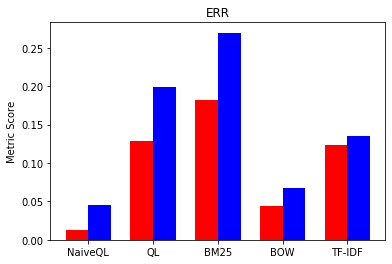

In [161]:
labels = ["ERR", "MAP", "Recall@1", "Recall@5", "Recall@10", "Precision@1", "Precision@5", "Precision@10"]
searches = ["NaiveQL", "QL", "BM25", "BOW", "TF-IDF"]

barWidth = 0.35
x_pos1 = np.arange(5)
x_pos2 = [x + barWidth for x in x_pos1]


for metric in labels:
    search1 = [results[1][search][metric] for search in searches]
    search2 = [results[2][search][metric] for search in searches]
    plt.bar(x_pos1, search1, barWidth, color='red')
    plt.bar(x_pos2, search2, barWidth, color='blue')
    
    plt.xticks([x + barWidth/2 for x in range(len(searches))], searches)
    plt.ylabel("Metric Score")
    plt.title(metric)
    p.legend(["Index 1", "Index 2"], loc=2)
    plt.show()

plt.show()

Write a summary of what you observe in the results.
You summary should compare results across the 2 indices and the methods being used. State what you expected to see in the results, followed by either supporting evidence *or* justify why the results did not support your expectations.      
*Hint*: You may build upon the answers from the previous sections. 

*TODO: Answer this!*